### Semantic features as word embeddings

In [5]:
import numpy as np
import os
import torch
import json
from tqdm import tqdm
import scipy
import pandas as pd

### Semantic features

In [14]:
min_len_line = 5
N_SEMANTIC_FEATURES = 25
semantic_features = {}

def dump_mitchell_web_semantic_features(raw_file = os.path.join("data","mitchell_semantic_raw.txt")):
    with open(raw_file, "r") as datafile:
        lines = datafile.readlines()
        word = None

        for line in lines:

            # Skip empty
            if len(line) >= min_len_line:

                # New feature
                if "Features for" in line:

                    # Discard invalid ones (once fully parsed)
                    if word and len(semantic_features[word]['features']) < N_SEMANTIC_FEATURES: del semantic_features[word] 
                        
                    word = line.split("<a name=\"")[1].split("\"")[0]
                    semantic_features[word] = { "features": [], "values": []}

                elif word:
                    feature_name = line.split("(")[0]
                    val = float(line.split("(")[1].split(")")[0])
                    semantic_features[word]["features"].append(feature_name)
                    semantic_features[word]["values"].append(val)

    # Save to file
    with open(os.path.join('data', 'mitchell_semantic_features.json'), 'w') as fp:
        json.dump(semantic_features, fp)

    return semantic_features

In [15]:
semantic_features = dump_mitchell_web_semantic_features()

### fMRI data

In [8]:
def get_mitchell_original_data(subject = 1, random_voxels = None):
    mdata = scipy.io.loadmat(os.path.join("data", "mitchell", f"mitchell_subject_{subject}.mat"))
    subject_data = {}

    # 6 x 60 trials
    for i in range(mdata["data"][:].shape[0]):
        cond, cond_number, word, word_number, epoch = [x[0] for x in mdata["info"][0][i]]

        # Set trial data
        if epoch[0] not in subject_data: subject_data[epoch[0]] = {}

        if random_voxels:
            random_voxels_idx = np.random.choice(mdata["data"][i][0][0].shape[0], random_voxels)
            subject_data[epoch[0]][word] = mdata["data"][i][0][0][random_voxels_idx]
        else: subject_data[epoch[0]][word] = mdata["data"][i][0][0]

    return subject_data

**Taking the most stable voxels**

Supplement online material Mitchell et al., page 6.

In [ ]:
K = 500
TRAIN_SIZE = 58
fmriData = get_mitchell_original_data(subject=1)
voxels = fmriData[1]["bell"].shape[0]

# Get scores of the voxels
scores = []
for vx in range(voxels):

    # Gathering epoch-wise brain activity
    repetitions = []
    for epoch in fmriData.keys():
        repetitions.append(np.array([fmriData[epoch][word][vx] for word in fmriData[epoch].keys()]))
    repetitions = np.array(repetitions)

    # Compute voxel scores
    voxel_correlation_score = []
    for i in range(repetitions.shape[0]):
        for j in range(i+1, repetitions.shape[0]):
            voxel_correlation_score.append(np.correlate(repetitions[i, :TRAIN_SIZE], repetitions[j, :TRAIN_SIZE]))

    voxel_correlation_score = np.array(voxel_correlation_score)
    scores.append(np.mean(voxel_correlation_score))

most_stable_voxels_idx = np.argpartition(scores, -K)[-K:]

In [29]:
# Filter and compute mean across repetitions
filteredfMRIData = {}
for epoch in fmriData.keys():
    for word, activations in fmriData[epoch].items():
        if word not in filteredfMRIData.keys(): filteredfMRIData[word] = []
        filteredfMRIData[word].append(activations[most_stable_voxels_idx])
        
for word in filteredfMRIData.keys():
    filteredfMRIData[word] = np.mean(filteredfMRIData[word], axis=0)

### Predicting

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
# Building train set
X = []
Y = []

for word in tqdm(semantic_features.keys()):
    if word in filteredfMRIData.keys():
        X.append(semantic_features[word]["values"])
        Y.append(filteredfMRIData[word])

100%|██████████| 60/60 [00:00<00:00, 60004.35it/s]


In [32]:
# Fetch fMRI activations from the dataset
X = np.array(X)
Y = np.array(Y)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.02, random_state=42)
X_train, X_test, y_train, y_test = X[:TRAIN_SIZE], X[TRAIN_SIZE:], Y[:TRAIN_SIZE], Y[TRAIN_SIZE:]


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(58, 25) (2, 25)
(58, 500) (2, 500)


In [33]:
# make_pipeline(StandardScaler(with_mean=False), LinearRegression())
predictors = [make_pipeline(StandardScaler(with_mean=False), LinearRegression()) for i in range(K)]
scores = []

# One predictor per voxel
i = 0
for model in tqdm(predictors):
    model.fit(X_train, y_train[:, i])
    scores.append(model.score(X_test, y_test[:, i]))
    i += 1

scores = np.array(scores)

100%|██████████| 500/500 [00:01<00:00, 262.81it/s]


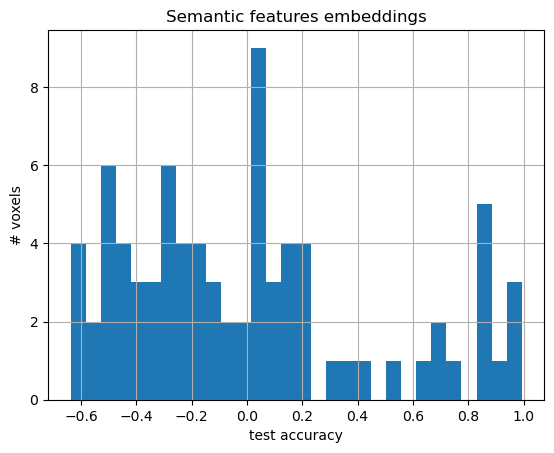

In [40]:
K = 80
ind = np.argpartition(scores, -K)[-K:]

plt.title("Semantic features embeddings")
plt.xlabel("test accuracy")
plt.ylabel("# voxels")
plt.hist(scores[ind], bins=30)
plt.grid()

(0.0, 1.0)

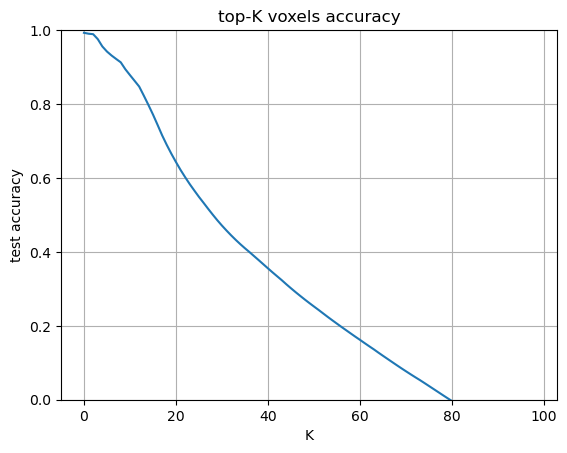

In [37]:
# Picking the best 100 predictors per voxel
subset_scores = [np.mean(scores[np.argpartition(scores, -subset_size)[-subset_size:]]) for subset_size in range(1, 100)]

plt.title("top-K voxels accuracy")
plt.plot(subset_scores)
plt.ylabel("test accuracy")
plt.xlabel("K")
plt.grid()
plt.ylim([0, 1])

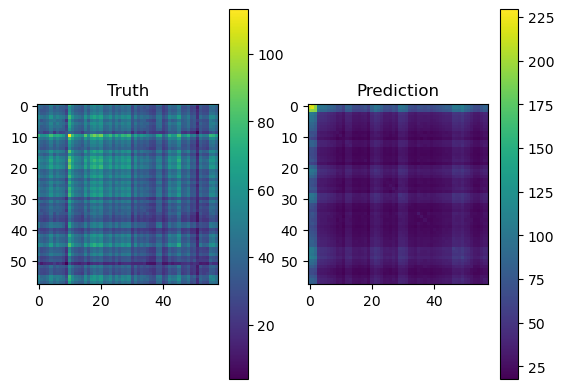

In [38]:
from scipy.stats import pearsonr

K = 20
ind = np.argpartition(scores, -K)[-K:]

# According to the last subject
def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels

y_hat = best_K_predict(X_train, ind, predictors)
y = y_train[:, ind]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))
# RDM_hat = (RDM_hat - RDM_hat.min()) / (RDM_hat.max() - RDM_hat.min())

RDM = np.matmul(y, np.matrix.transpose(y))
# RDM = (RDM - RDM.min()) / (RDM.max() - RDM.min())

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

plt.subplot(121)
plt.title("Truth")
plt.imshow(RDM)
plt.colorbar()

plt.subplot(122)
plt.title("Prediction")
plt.imshow(RDM_hat)
plt.colorbar()